In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

In [2]:
# import MNIST data
digits = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

In [513]:
digit_values = digits.data
digit_labels = digits.targets

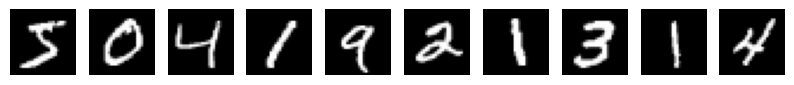

In [514]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(digit_values[i], cmap='gray')
    axs[i].axis('off')

plt.show()

In [515]:
# split data into training and validation sets
from sklearn.model_selection import train_test_split

train_values, val_values, train_labels, val_labels = train_test_split(digit_values, digit_labels, test_size=0.1)

In [527]:
class NoisyMNIST(Dataset):
    def __init__(self, x, transform=None):
        self.image = x/255.0
        self.label = x.clone()/255.0
        self.transform = transform

    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        image = self.image[idx]
        label = self.label[idx]
        image = np.array(image)
        if self.transform:
            image = self.transform(image)
        # make sure floats
        return image.float(), label.float()


In [510]:
def add_noise(x, noise_factor):  # Random noise factor between 0 and 0.5
    noisy_x = x + noise_factor * np.random.randn(*x.shape)
    noisy_x = np.clip(noisy_x, 0., 1.)
    return noisy_x

In [528]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = NoisyMNIST(train_values, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = NoisyMNIST(val_values, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [508]:
train_dataset.image.shape

torch.Size([54000, 28, 28])

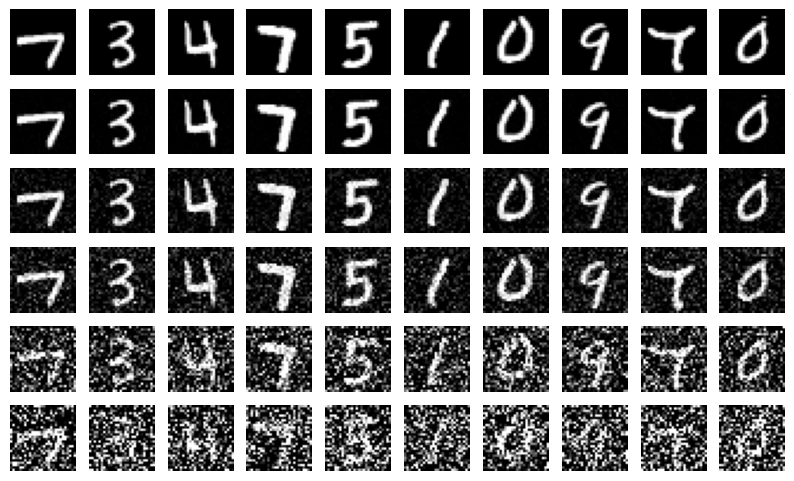

In [131]:
sample_x = train_dataset.image[:10]

eps = [0, 0.01, 0.1, 0.2, 0.5, 0.8]

fig, axs = plt.subplots(6, 10, figsize=(10, 6))
for i, e in enumerate(eps):
    for j in range(10):
        axs[i, j].imshow(add_noise(sample_x[j], e).numpy(), cmap='gray')
        axs[i, j].axis('off')

In [132]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 8),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28*28),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [135]:
BATCH_SIZE = 32

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10

train_loss = []
test_loss = []

for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss.append(np.mean(train_losses))

    model.eval()
    test_losses = []
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        outputs = model(img)
        loss = criterion(outputs, img)
        test_losses.append(loss.item())
    test_loss.append(np.mean(test_losses))

    print(f'Epoch {epoch}, Train loss: {train_loss[-1]}, Test loss: {test_loss[-1]}')

Epoch 0, Train loss: 0.09232097585636999, Test loss: 0.08563985251524348
Epoch 1, Train loss: 0.08442083214325787, Test loss: 0.08290516775339207
Epoch 2, Train loss: 0.0829877821260719, Test loss: 0.08209242921401845
Epoch 3, Train loss: 0.08265427137853057, Test loss: 0.0826771025486449
Epoch 4, Train loss: 0.08185838608035897, Test loss: 0.0821625713377874
Epoch 5, Train loss: 0.08215001358328414, Test loss: 0.08120660594803222
Epoch 6, Train loss: 0.08160661792788672, Test loss: 0.08168779995213164
Epoch 7, Train loss: 0.08094696377258377, Test loss: 0.08145708638302823
Epoch 8, Train loss: 0.08088965096921436, Test loss: 0.08091657392759906
Epoch 9, Train loss: 0.08093843511989897, Test loss: 0.08072389428444365


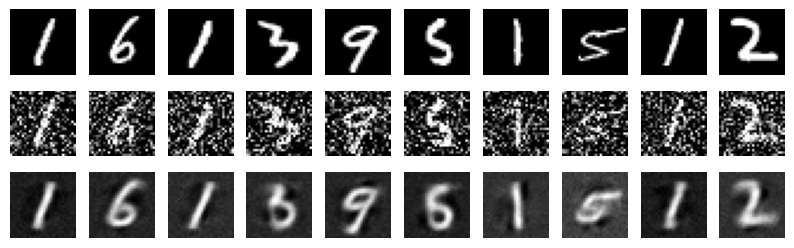

In [138]:
# 10 random integers
idx = np.random.randint(0, len(test_dataset), 10)
sample_x = train_dataset.image[idx]
sample_x_noisy = add_noise(sample_x, 0.5)

fig, axs = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    axs[0, i].imshow(sample_x[i], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(sample_x_noisy[i], cmap='gray')
    axs[1, i].axis('off')
    axs[2, i].imshow(model(sample_x_noisy[i].view(1, -1).float()).detach().numpy().reshape(28, 28), cmap='gray')
    axs[2, i].axis('off')

In [139]:
encoder = model.encoder
decoder = model.decoder

In [140]:
digit_sample = digit_values[:10000]/255.0
label_sample = digit_labels[:10000]

In [141]:
latent = encoder(digit_sample)

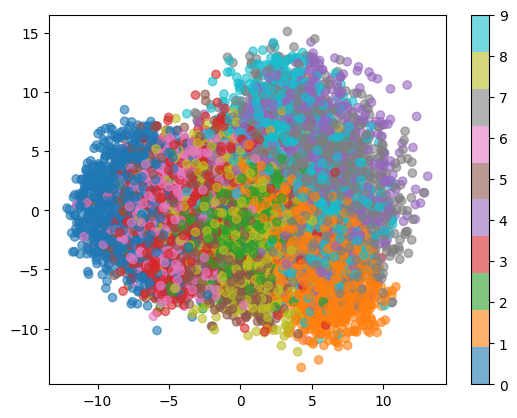

In [142]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent.detach().numpy())

plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=label_sample, cmap='tab10', alpha=0.6)
plt.colorbar()

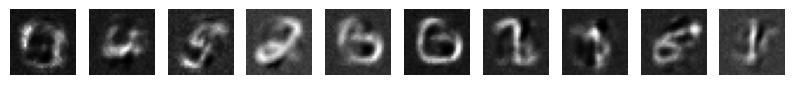

In [146]:
# sample some values from latent space
n = 10
x = torch.randn(n, 8)
x = decoder(x)

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(x[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i].axis('off')

plt.show()

# VAE

In [128]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

# Download training data from open datasets.
train_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)


test_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [172]:
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [173]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 16)
        # Decoder
        self.fc4 = nn.Linear(8, 32)
        self.fc5 = nn.Linear(32, 128)
        self.fc6 = nn.Linear(128, 784)

    def encode(self, x):
        h1 = nn.functional.gelu(self.fc1(x))
        h2 = nn.functional.gelu(self.fc2(h1))
        h3 = nn.functional.gelu(self.fc3(h2))

        mu, logvar = torch.chunk(h3, 2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = nn.functional.gelu(self.fc4(z))
        h5 = nn.functional.gelu(self.fc5(h4))
        return torch.sigmoid(self.fc6(h5))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [170]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        img, _ = data
        img = img.view(img.size(0), -1)
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [174]:
epochs = 10
batch_size = 32
lr = 1e-3
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)

====> Epoch: 1 Average loss: 82.6871
====> Epoch: 2 Average loss: 81.0020
====> Epoch: 3 Average loss: 80.4333
====> Epoch: 4 Average loss: 80.2251
====> Epoch: 5 Average loss: 79.7698
====> Epoch: 6 Average loss: 79.6135
====> Epoch: 7 Average loss: 79.4677
====> Epoch: 8 Average loss: 79.4463
====> Epoch: 9 Average loss: 79.3721
====> Epoch: 10 Average loss: 79.6666


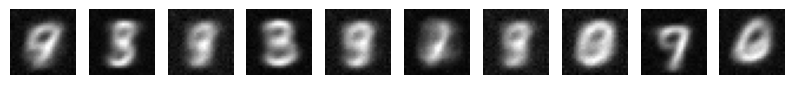

In [178]:
n = 10
x = torch.randn(n, 8)
x = model.decode(x)

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(x[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i].axis('off')

plt.show()

In [179]:
# look at latent space of digit_sample
encoder = model.encode
# must use digit_sample
latent = encoder(digit_sample.view(-1, 784))[0]

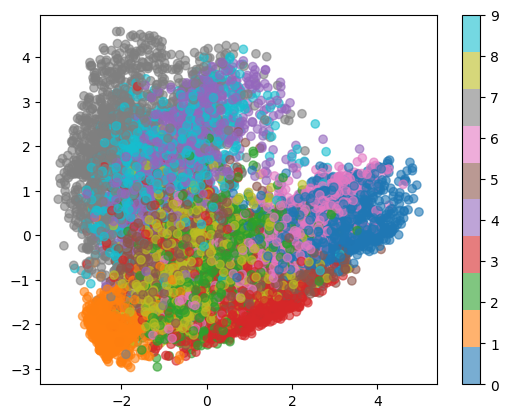

In [180]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent.detach().numpy())

plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=label_sample, cmap='tab10', alpha=0.6)
plt.colorbar()